# H-DNA T2T

## Data Download

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!mkdir -p datasets/

#### Download Telomeres

In [3]:
# download alu and sva elements
!wget -q -P datasets/ https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/annotation/chm13v2.0_RepeatMasker_4.1.2p1.2022Apr14.out
# download GFF
!wget -q -P datasets/ https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/914/755/GCF_009914755.1_T2T-CHM13v2.0/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz
# download centromeric and pericentromeric compartments
!wget -q -P datasets/ https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/annotation/chm13v2.0_censat_v2.1.bed

### Imports

In [38]:
from pathlib import Path
import gzip
import dotenv
from tqdm import tqdm
import os
from termcolor import colored
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools
from pybedtools import BedTool

In [63]:
MIRROR_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/mirrors/chm13v2.0_MR.processed.tsv")
CENTROMERE_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/primates/centromeres/chm13v2.0_censat_v2.0.bed")
GFF_PATH = Path("/storage/group/izg5139/default/nicole/datasets/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz")
GENOME_PATH = Path("genome.txt")

In [64]:
mirror_df = pd.read_table(MIRROR_PATH)
mirror_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition
0,chr1,1710,1752,accccaaccccaaccccaacc,.,accccaaccccaaccccaaccccaaccccaaccccaacccca,21,0,42,7,0,14,0,7A/14C/0G/0T
1,chr1,1712,1756,cccaaccccaaccccaacccca,.,cccaaccccaaccccaaccccaaccccaaccccaaccccaaccc,22,0,44,7,0,15,0,7A/15C/0G/0T
2,chr1,6739,6764,acaaaaataa,aagcc,acaaaaataaaagccaataaaaaca,10,5,25,8,0,1,1,8A/1C/0G/1T
3,chr1,17295,17316,aaaataaata,a,aaaataaataaataaataaaa,10,1,21,8,0,0,2,8A/0C/0G/2T
4,chr1,17607,17628,aaaaaacaaa,c,aaaaaacaaacaaacaaaaaa,10,1,21,9,0,1,0,9A/1C/0G/0T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256987,chrY,62453725,62453769,ttggggttggggttggggttgg,.,ttggggttggggttggggttggggttggggttggggttggggtt,22,0,44,0,14,0,8,0A/0C/14G/8T
1256988,chrY,62453777,62453814,gggtgggggtgggggtgg,g,gggtgggggtgggggtgggggtgggggtgggggtggg,18,1,37,0,15,0,3,0A/0C/15G/3T
1256989,chrY,62453779,62453818,gtgggggtgggggtggggg,t,gtgggggtgggggtgggggtgggggtgggggtgggggtg,19,1,39,0,16,0,3,0A/0C/16G/3T
1256990,chrY,62453862,62453919,gggttggggttggggttggggttgggg,tta,gggttggggttggggttggggttggggttaggggttggggttgggg...,27,3,57,0,19,0,8,0A/0C/19G/8T


In [65]:
mirror_df["spacerLength"].max(), mirror_df["spacerLength"].min()

(7, 0)

In [66]:
mirror_df["armLength"].max(), mirror_df["armLength"].min()

(398, 10)

In [67]:
mirror_df["sequenceLength"].max(), mirror_df["sequenceLength"].min()

(797, 20)

In [68]:
def get_hdna_table(mirror_table):
    mirror_table.loc[:, "at"] = mirror_table["sequence"].str.count("a|t").div(mirror_table["sequenceLength"])
    mirror_table.loc[:, "ag"] = mirror_table["sequence"].str.count("a|g").div(mirror_table["sequenceLength"])
    mirror_table.loc[:, "ct"] = mirror_table["sequence"].str.count("c|t").div(mirror_table["sequenceLength"])
    
    hdna_df = mirror_table[(mirror_table["at"] < 0.8) & ((mirror_table["ag"] >= 0.9) | (mirror_table["ct"] >= 0.9))]
    return hdna_df

hdna_df = get_hdna_table(mirror_df)
hdna_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,at,ag,ct
10,chr1,50042,50071,ggagggaggga,ggcagaa,ggagggagggaggcagaaagggagggagg,11,7,29,3,8,0,0,3A/0C/8G/0T,0.310345,0.965517,0.034483
11,chr1,50059,50086,aagggaggga,ggcagaa,aagggagggaggcagaaagggagggaa,10,7,27,4,6,0,0,4A/0C/6G/0T,0.407407,0.962963,0.037037
12,chr1,50082,50111,ggaaggaagga,gcaagga,ggaaggaaggagcaaggaaggaaggaagg,11,7,29,5,6,0,0,5A/0C/6G/0T,0.448276,0.965517,0.034483
13,chr1,50095,50117,aaggaaggaag,.,aaggaaggaaggaaggaaggaa,11,0,22,6,5,0,0,6A/0C/5G/0T,0.545455,1.000000,0.000000
14,chr1,50097,50119,ggaaggaagga,.,ggaaggaaggaaggaaggaagg,11,0,22,5,6,0,0,5A/0C/6G/0T,0.454545,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256887,chrY,62192837,62192864,ctctctctctctc,t,ctctctctctctctctctctctctctc,13,1,27,0,0,7,6,0A/7C/0G/6T,0.481481,0.000000,1.000000
1256900,chrY,62247108,62247130,aaagaaggaag,.,aaagaaggaaggaaggaagaaa,11,0,22,7,4,0,0,7A/0C/4G/0T,0.636364,1.000000,0.000000
1256901,chrY,62247260,62247284,gggagggagg,ggat,gggagggaggggatggagggaggg,10,4,24,2,8,0,0,2A/0C/8G/0T,0.250000,0.958333,0.041667
1256903,chrY,62255805,62255833,aggaggaggaggag,.,aggaggaggaggaggaggaggaggagga,14,0,28,5,9,0,0,5A/0C/9G/0T,0.357143,1.000000,0.000000


## Human Chromosomes

In [69]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [70]:
sns.color_palette("Set3")

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [71]:
chromosome_map = {
    'metacentric': ['chr1', 'chr3', 'chr16', 'chr19', 'chr20'],
    'submetacentric': ['chr2', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr17', 'chr18'],
    'acrocentric': ['chr13', 'chr14', 'chr15', 'chr21', 'chr22']
}

chromosome_map = {'chr1': 'Metacentric',
                  'chr3': 'Metacentric',
                  'chr16': 'Metacentric',
                  'chr19': 'Metacentric',
                  'chr20': 'Metacentric',
                  'chr2': 'Submetacentric',
                  'chr4': 'Submetacentric',
                  'chr5': 'Submetacentric',
                  'chr6': 'Submetacentric',
                  'chr7': 'Submetacentric',
                  'chr8': 'Submetacentric',
                  'chr9': 'Submetacentric',
                  'chr10': 'Submetacentric',
                  'chr11': 'Submetacentric',
                  'chr12': 'Submetacentric',
                  'chr17': 'Submetacentric',
                  'chr18': 'Submetacentric',
                  'chrX': 'Submetacentric',
                  'chr13': 'Acrocentric',
                  'chr14': 'Acrocentric',
                  'chr15': 'Acrocentric',
                  'chr21': 'Acrocentric',
                  'chr22': 'Acrocentric',
                  'chrY': 'Acrocentric',
                  'chrM': 'Mitochondrial',
                 }

morphology_colors = {
          'Metacentric': sns.color_palette("Set2")[4],
          'Mitochondrial': sns.color_palette("Set2")[4],
          'Acrocentric': sns.color_palette("Set2")[5],
          'Submetacentric': sns.color_palette("Set2")[4]
         }

In [72]:
human_chromosomes = pd.read_table(GENOME_PATH, header=None, names=["seqID", "size"])
human_chromosomes.loc[:, "morphology"] = human_chromosomes["seqID"].map(chromosome_map)
human_chromosomes

,seqID,size,morphology
0,chr1,248387328,Metacentric
1,chr2,242696752,Submetacentric
2,chr3,201105948,Metacentric
3,chr4,193574945,Submetacentric
4,chr5,182045439,Submetacentric
5,chr6,172126628,Submetacentric
6,chr7,160567428,Submetacentric
7,chr8,146259331,Submetacentric
8,chr9,150617247,Submetacentric
9,chr10,134758134,Submetacentric


## H-DNA Density across the Human Chromosomes

In [66]:
mirror_merged = pd.read_table(BedTool.from_dataframe(mirror_df[["seqID", "start", "end"]])
                                    .sort()
                                    .merge().fn,
                                    header=None,
                                    names=["seqID", "start", "end"]
                                )\
                    .merge(human_chromosomes, on="seqID", how="left")
mirror_merged.loc[:, "length"] = mirror_merged["end"] - mirror_merged["start"]

# Calculate G4 Odds Genome Wide
total_G4bp = mirror_merged['length'].sum()
genome_size = mirror_merged.groupby("seqID").agg({"size": "first"})['size'].sum()
G4_odds_genome_wide = total_G4bp / (genome_size - total_G4bp)

print(f"Genome Size {genome_size}.")
print(f"Total Motifs BP: {total_G4bp}. (G4 Hunter)")

# Calculate G4 Odds Enrichment for each chromosome
mirror_merged = ( mirror_merged.groupby("seqID", as_index=False)
                                     .agg(
                                        totalG4BP=("length", "sum"), 
                                         size=("size", "first"),
                                         morphology=("morphology", "first"),
                                     )
                   )

mirror_merged["odds"] = mirror_merged["totalG4BP"] / (mirror_merged["size"] - mirror_merged["totalG4BP"])
mirror_merged["log_enrichment"] =  np.log10(mirror_merged["odds"] / G4_odds_genome_wide)
mirror_merged["coverage"] = 1e6 * mirror_merged["totalG4BP"].div(mirror_merged['size'])
mirror_merged

Genome Size 3117275501.
Total Motifs BP: 27338921. (G4 Hunter)


,seqID,totalG4BP,size,morphology,odds,log_enrichment,coverage
0,chr1,2048500,248387328,Metacentric,0.008316,-0.026929,8247.200115
1,chr10,1179795,134758134,Submetacentric,0.008832,-0.000761,8754.907515
2,chr11,1092637,135127769,Submetacentric,0.008152,-0.035575,8085.954561
3,chr12,1194791,133324548,Submetacentric,0.009043,0.009460,8961.522975
4,chr13,1232102,113566686,Acrocentric,0.010968,0.093301,10849.149899
5,chr14,880072,101161492,Acrocentric,0.008776,-0.003534,8699.673983
6,chr15,982998,99753195,Acrocentric,0.009952,0.051095,9854.300907
7,chr16,869076,96330374,Metacentric,0.009104,0.012399,9021.827321
8,chr17,855461,84276897,Submetacentric,0.010255,0.064091,10150.599161
9,chr18,636098,80542538,Submetacentric,0.007961,-0.045890,7897.665206


In [108]:
!pwd

/storage/home/nmc6088


In [67]:
hdna_merged = pd.read_table(BedTool.from_dataframe(hdna_df[["seqID", "start", "end"]])
                                    .sort()
                                    .merge().fn,
                                    header=None,
                                    names=["seqID", "start", "end"]
                                )\
                    .merge(human_chromosomes, on="seqID", how="left")
hdna_merged.loc[:, "length"] = hdna_merged["end"] - hdna_merged["start"]

# Genome Wide G4 Odds
total_G4bp = hdna_merged['length'].sum()
genome_size = hdna_merged.groupby("seqID").agg({"size": "first"})['size'].sum()
G4_odds_genome_wide = total_G4bp / (genome_size - total_G4bp)

print(f"CHM13v2 Genome Size: {genome_size}.")
print(f"Total Motifs BP: {total_G4bp} (Consensus Motif).")

# Calculate G4 Odds Enrichment for each chromosome
hdna_merged = ( hdna_merged.groupby("seqID", as_index=False)
                                .agg(
                                     totalG4BP=("length", "sum"), 
                                     size=("size", "first"),
                                     morphology=("morphology", "first"),
                                )
                   )
hdna_merged["odds"] = hdna_merged["totalG4BP"] / (hdna_merged["size"] - hdna_merged["totalG4BP"])
hdna_merged["log_enrichment"] =  np.log10(hdna_merged["odds"] / G4_odds_genome_wide)
hdna_merged["coverage"] = 1e6 * hdna_merged["totalG4BP"].div(hdna_merged['size'])
hdna_merged

CHM13v2 Genome Size: 3117275501.
Total Motifs BP: 4953001 (Consensus Motif).


,seqID,totalG4BP,size,morphology,odds,log_enrichment,coverage
0,chr1,348916,248387328,Metacentric,0.001407,-0.053582,1404.725446
1,chr10,198716,134758134,Submetacentric,0.001477,-0.032465,1474.612286
2,chr11,178710,135127769,Submetacentric,0.001324,-0.079805,1322.526090
3,chr12,196286,133324548,Submetacentric,0.001474,-0.033165,1472.242006
4,chr13,393095,113566686,Acrocentric,0.003473,0.338969,3461.358378
5,chr14,173782,101161492,Acrocentric,0.001721,0.033952,1717.867111
6,chr15,253199,99753195,Acrocentric,0.002545,0.203855,2538.254539
7,chr16,164481,96330374,Metacentric,0.001710,0.031311,1707.467678
8,chr17,132356,84276897,Submetacentric,0.001573,-0.005066,1570.489716
9,chr18,96930,80542538,Submetacentric,0.001205,-0.120828,1203.463442


In [68]:
both_methods = pd.concat([
                        hdna_merged.assign(method="H-DNA"),
                        mirror_merged.assign(method="Mirror Repeat")
                    ])
both_methods

,seqID,totalG4BP,size,morphology,odds,log_enrichment,coverage,method
0,chr1,348916,248387328,Metacentric,0.001407,-0.053582,1404.725446,H-DNA
1,chr10,198716,134758134,Submetacentric,0.001477,-0.032465,1474.612286,H-DNA
2,chr11,178710,135127769,Submetacentric,0.001324,-0.079805,1322.526090,H-DNA
3,chr12,196286,133324548,Submetacentric,0.001474,-0.033165,1472.242006,H-DNA
4,chr13,393095,113566686,Acrocentric,0.003473,0.338969,3461.358378,H-DNA
5,chr14,173782,101161492,Acrocentric,0.001721,0.033952,1717.867111,H-DNA
6,chr15,253199,99753195,Acrocentric,0.002545,0.203855,2538.254539,H-DNA
7,chr16,164481,96330374,Metacentric,0.001710,0.031311,1707.467678,H-DNA
8,chr17,132356,84276897,Submetacentric,0.001573,-0.005066,1570.489716,H-DNA
9,chr18,96930,80542538,Submetacentric,0.001205,-0.120828,1203.463442,H-DNA


In [69]:
figures = Path("mirror_figures")
figures.mkdir(exist_ok=True)

In [70]:
mirror_color = sns.color_palette("Set3")[2]
hdna_color = sns.color_palette("Set2")[2]

In [71]:
human_chromosomes.head()

,seqID,size,morphology
0,chr1,248387328,Metacentric
1,chr2,242696752,Submetacentric
2,chr3,201105948,Metacentric
3,chr4,193574945,Submetacentric
4,chr5,182045439,Submetacentric


In [72]:
# t = hdna_df.merge(human_chromosomes)\
#             .groupby("seqID", as_index=False)\
#             .agg({"sequenceLength": "sum", "size": "first"})\
#             .assign(coverage=lambda ds: 1e6 * ds['sequenceLength'] / ds['size'])\
#             .sort_values(by=['coverage'], ascending=False)\
#             .reset_index(drop=True)
# t

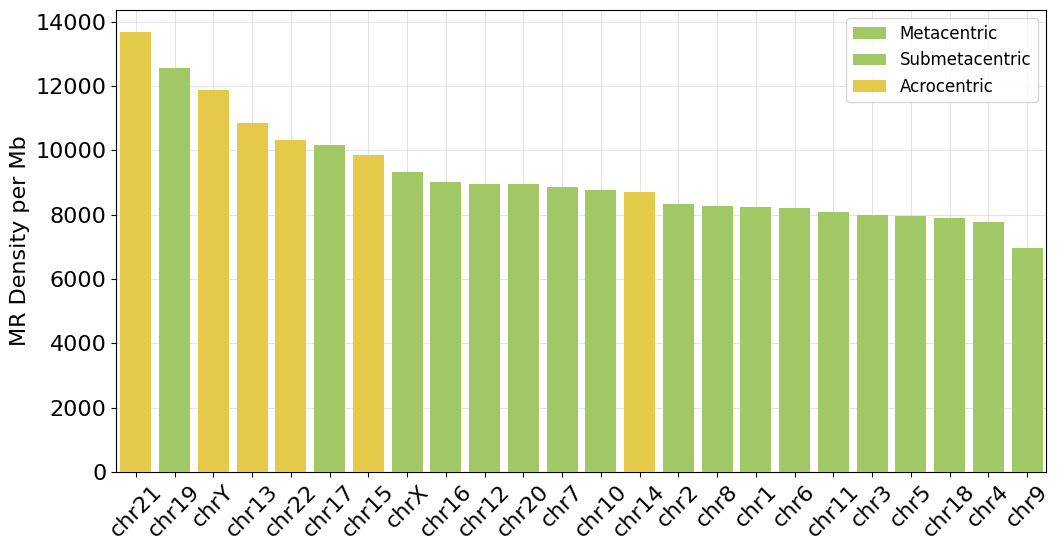

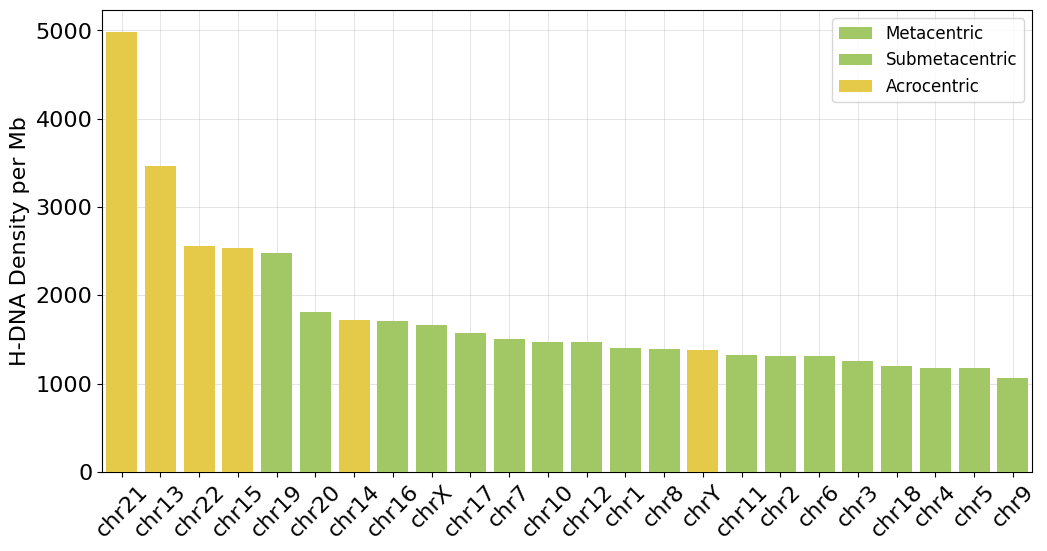

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=mirror_merged,
            x="seqID",
            dodge=False,
            y="coverage",
            palette=morphology_colors,
            hue="morphology",
            order=mirror_merged.set_index('seqID')['coverage'].sort_values(ascending=False).index.tolist(),
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 12})
ax.set_ylabel("MR Density per Mb")
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=45)
fig.savefig(figures.joinpath("MR_total_coverage_per_chromosome.png"), bbox_inches='tight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=hdna_merged,
            x="seqID",
            dodge=False,
            y="coverage",
            palette=morphology_colors,
            hue="morphology",
            order=hdna_merged.set_index('seqID')['coverage'].sort_values(ascending=False).index.tolist(),
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 12})
ax.set_ylabel("H-DNA Density per Mb")
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=45)
fig.savefig(figures.joinpath("hdna_total_coverage_per_chromosome.png"), bbox_inches='tight')

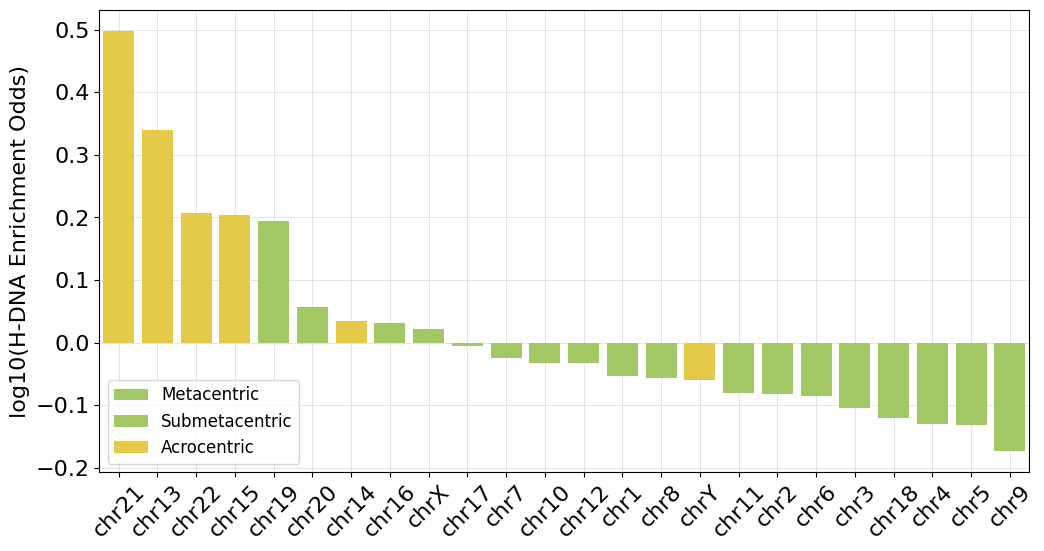

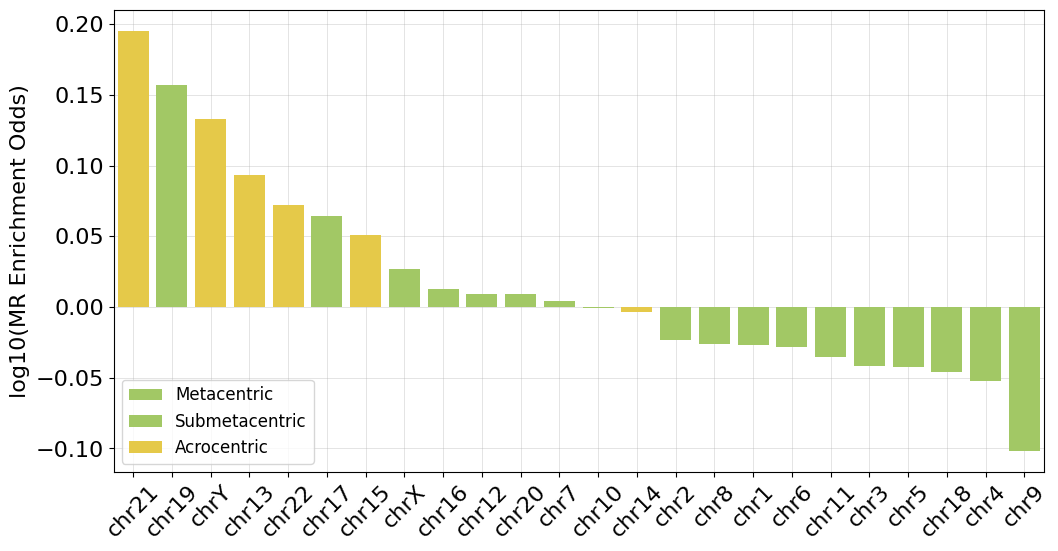

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=hdna_merged,
            x="seqID",
            y="log_enrichment",
            dodge=False,
            palette=morphology_colors,
            hue="morphology",
            order=hdna_merged.set_index('seqID')['odds'].sort_values(ascending=False).index.tolist(),
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 12})
ax.set_ylabel("log10(H-DNA Enrichment Odds)")
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=45)
fig.savefig(figures.joinpath("hdna_odds_log10_enrichment_per_chromosome.png"), bbox_inches='tight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=mirror_merged,
            x="seqID",
            y="log_enrichment",
            dodge=False,
            palette=morphology_colors,
            hue="morphology",
            order=mirror_merged.set_index('seqID')['odds'].sort_values(ascending=False).index.tolist(),
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 12})
ax.set_ylabel("log10(MR Enrichment Odds)")
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=45)
fig.savefig(figures.joinpath("mirror_odds_log10_enrichment_per_chromosome.png"), bbox_inches='tight')

In [19]:
from scipy.stats import ks_2samp

In [22]:
figures = Path("HDNA_figures")

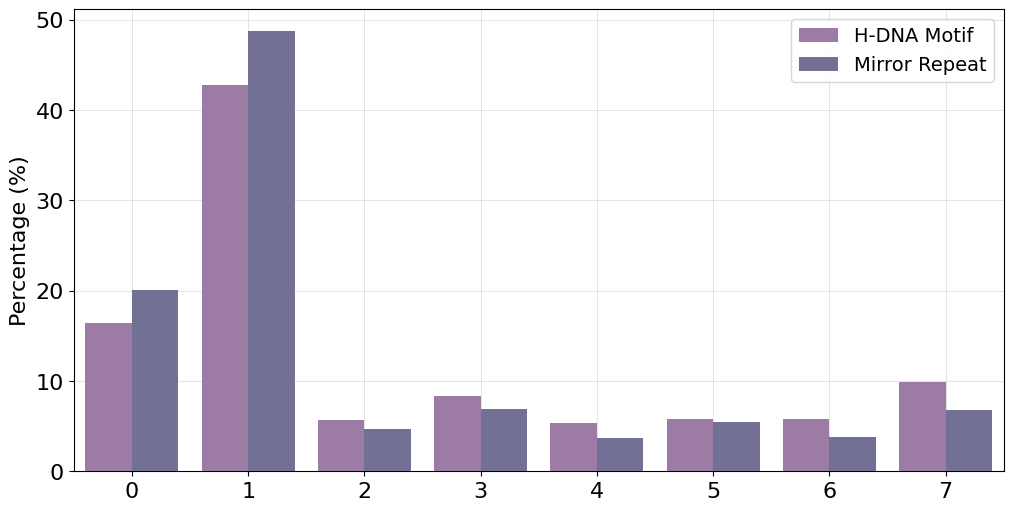

In [23]:
hdna_df_spacer_counts = (1e2 * hdna_df.spacerLength.value_counts(normalize=True)).to_frame(name='counts').reset_index()
mirror_df_spacer_counts = (1e2 * mirror_df.spacerLength.value_counts(normalize=True)).to_frame(name='counts').reset_index()
df_spacer_counts = pd.concat([
                              hdna_df_spacer_counts.assign(method="H-DNA Motif"),
                              mirror_df_spacer_counts.assign(method="Mirror Repeat")
                             ])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=df_spacer_counts,
            x="spacerLength",
            y="counts",
            # dodge=False,
            hue="method",
            palette={"Mirror Repeat": "#6c6b9b",
                     "H-DNA Motif": "#a074ac"
                    },
            hue_order=['H-DNA Motif', 'Mirror Repeat'],
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 14})
ax.set_ylabel("Percentage (%)")
ax.tick_params(axis="both", labelsize=16)
fig.savefig(figures.joinpath("mirror_hdna_biophysical_spacer.png"), bbox_inches='tight')

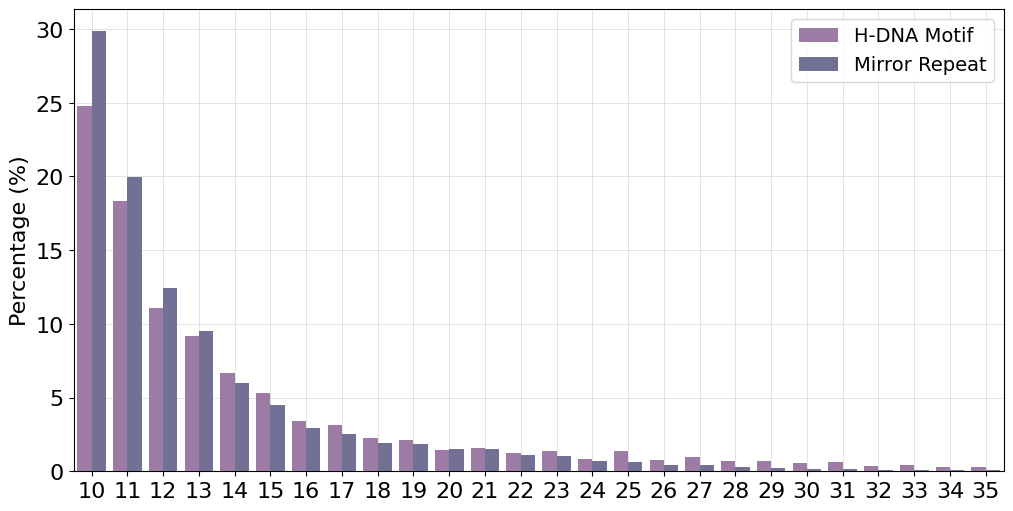

In [24]:
hdna_df_arm_counts = (1e2 * hdna_df.query("armLength < 36").armLength.value_counts(normalize=True)).to_frame(name='counts').reset_index()
mirror_df_arm_counts = (1e2 * mirror_df.query("armLength < 36").armLength.value_counts(normalize=True)).to_frame(name='counts').reset_index()
df_arm_counts = pd.concat([
                              hdna_df_arm_counts.assign(method="H-DNA Motif"),
                              mirror_df_arm_counts.assign(method="Mirror Repeat")
                             ])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=df_arm_counts,
            x="armLength",
            y="counts",
            palette={"Mirror Repeat": "#6c6b9b",
                     "H-DNA Motif": "#a074ac"
                    },
            # dodge=False,
            hue="method",
            hue_order=['H-DNA Motif', 'Mirror Repeat'],
            ax=ax,
            zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.legend(title='', prop={'size': 14})
ax.set_ylabel("Percentage (%)")
ax.tick_params(axis="both", labelsize=16)
fig.savefig(figures.joinpath("mirror_hdna_biophysical_arm.png"), bbox_inches='tight')

# Load Centromeric and PeriCentromeric Compartments

- Active αSat HOR (hor ... L) 	red
- Inactive αSat HOR (hor) 	orange
- Divergent αSat HOR (dhor) 	dark red
- Monomeric αSat (mon) 	peach/yellow
- Classical Human Satellite 1A (hsat1A) 	light green
- Classical Human Satellite 1B (hsat1B) 	dark green
- Classical Human Satellite 2 (hsat2) 	light blue
- Classical Human Satellite 3 (hsat3) 	blue
- Beta Satellite (bsat) 	pink
- Gamma Satellite (gsat) 	purple
- Other centromeric satellites (censat) 	teal
- Centromeric transition regions (ct) 	grey

In [25]:
CENTROMERIC_REGIONS = {
                       "hor": "Higher Order Repeats",
                       "dhor": "Inactive?",
                       "mon": "Monomeric",
                       "hsat1A": "Classical Human Satellite 1A",
                       "hsat1B": "Classical Human Satellite 1B",
                       "hsat2": "Classical Human Satellite 2",
                       "hsat3": "Classical Human Satellite 3",
                       "bsat": "Beta Satellite",
                       "gsat": "Gamma Satellite",
                       "censat": "Other centromeric satellites",
                       "ct": "Centromeric transition regions"
                      }

telomere_df = pd.read_table(TELOMERE_PATH, header=None, names=["seqID", "start", "end"])
telomere_df.loc[:, "compartment"] = "Telomere"

centromere_df = pd.read_table(CENTROMERE_PATH, 
                              skiprows=1, 
                              header=None, 
                              usecols=range(4), 
                              names=["seqID", "start", "end", "compartment"])
centromere_df.loc[:, "compartment"] = centromere_df["compartment"].apply(lambda x: x.split("_")[0])
centromere_df

,seqID,start,end,compartment
0,chr1,116796047,121405145,ct
1,chr1,121405145,121406286,censat
2,chr1,121406286,121619169,ct
3,chr1,121619169,121625213,hor
4,chr1,121625213,121667941,hor
...,...,...,...,...
2518,chrY,62025776,62037362,censat
2519,chrY,62052955,62059882,censat
2520,chrY,62061431,62072743,hsat3
2521,chrY,62072743,62087298,bsat


In [26]:
# Merge the overlapping compartments
unique_compartments = centromere_df['compartment'].unique()
unique_compartments

merged_centromeric_compartments = []
for compartment in tqdm(unique_compartments):
    centro_bed = (
                    BedTool.from_dataframe(centromere_df[centromere_df['compartment'] == compartment])
                    .sort()
                    .merge()
                )
    temp_centro = pd.read_table(
                    centro_bed.fn,
                    header=None,
                    names=["seqID", "start", "end"]
    )
    temp_centro.loc[:, "compartment"] = compartment
    merged_centromeric_compartments.append(temp_centro)
    
merged_centromeric_compartments = pd.concat(merged_centromeric_compartments, axis=0)
merged_centromeric_compartments_bed = BedTool.from_dataframe(merged_centromeric_compartments)
merged_centromeric_compartments

100%|██████████| 12/12 [00:00<00:00, 65.10it/s]


,seqID,start,end,compartment
0,chr1,116796047,121405145,ct
1,chr1,121406286,121619169,ct
2,chr1,121788213,121790362,ct
3,chr1,126838321,126840458,ct
4,chr1,126848989,126877724,ct
...,...,...,...,...
0,chr13,5770548,9348041,rDNA
1,chr14,2099537,2817811,rDNA
2,chr15,2506442,4707485,rDNA
3,chr21,3108298,5612715,rDNA


In [40]:
sequence_report = pd.read_table("sequence_report.tsv")
CHROMOSOME_MAPPING = sequence_report[["Chromosome name", "RefSeq seq accession"]].set_index("RefSeq seq accession")
CHROMOSOME_MAPPING["Chromosome name"] = CHROMOSOME_MAPPING["Chromosome name"].apply(lambda chr: f"chr{chr}")
CHROMOSOME_MAPPING = CHROMOSOME_MAPPING["Chromosome name"].to_dict()
CHROMOSOME_MAPPING

{'NC_060925.1': 'chr1',
 'NC_060926.1': 'chr2',
 'NC_060927.1': 'chr3',
 'NC_060928.1': 'chr4',
 'NC_060929.1': 'chr5',
 'NC_060930.1': 'chr6',
 'NC_060931.1': 'chr7',
 'NC_060932.1': 'chr8',
 'NC_060933.1': 'chr9',
 'NC_060934.1': 'chr10',
 'NC_060935.1': 'chr11',
 'NC_060936.1': 'chr12',
 'NC_060937.1': 'chr13',
 'NC_060938.1': 'chr14',
 'NC_060939.1': 'chr15',
 'NC_060940.1': 'chr16',
 'NC_060941.1': 'chr17',
 'NC_060942.1': 'chr18',
 'NC_060943.1': 'chr19',
 'NC_060944.1': 'chr20',
 'NC_060945.1': 'chr21',
 'NC_060946.1': 'chr22',
 'NC_060947.1': 'chrX',
 'NC_060948.1': 'chrY'}

### Loading GFF

In [41]:
gff_df = pd.read_table(GFF_PATH, 
                         usecols=[0, 2, 3, 4, 6, 8], 
                         header=None, 
                         comment="#",
                         names=["seqID", "compartment", "start", "end", "strand", "attributes"]
                        )
gff_df["start"] = gff_df["start"] - 1
gff_df["seqID"] = gff_df["seqID"].map(CHROMOSOME_MAPPING)
unique_gff_compartments = list(gff_df["compartment"].unique())

# fetch unique compartments
selected_unique_gff_compartments = ["gene", "exon", "CDS", "region", "silencer", "enhancer"]
NAME_MAPPING = {"gene": "Gene", 
                "exon": "Exon", 
                "CDS": "CDS", 
                "region": "Genome", 
                "silencer": "Silencer", 
                "enhancer": "Enhancer"}

merged_gff_df = []
for compartment in tqdm(selected_unique_gff_compartments, total=len(selected_unique_gff_compartments)):
    temp = gff_df[gff_df["compartment"] == compartment]
    if temp.shape[0] == 0:
        print(f"Compartment {compartment} is NOT annotated.\n")
        continue
    temp_bed = BedTool.from_dataframe(temp[["seqID", "start", "end"]])\
                        .sort().merge()
    temp_df = pd.read_table(temp_bed.fn, header=None, names=["seqID", "start", "end"])
    temp_df.loc[:, "compartment"] = NAME_MAPPING[compartment]
    merged_gff_df.append(temp_df)
merged_gff_df = pd.concat(merged_gff_df)
merged_gff_df

100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


,seqID,start,end,compartment
0,chr1,7505,138480,Gene
1,chr1,152268,205171,Gene
2,chr1,205334,238971,Gene
3,chr1,246377,248841,Gene
4,chr1,255177,256494,Gene
...,...,...,...,...
85563,chrY,62080838,62081381,Enhancer
85564,chrY,62082582,62083084,Enhancer
85565,chrY,62086108,62086608,Enhancer
85566,chrY,62332803,62333355,Enhancer


### Merged Compartments

In [42]:
compartments_concatenated_df = pd.concat([
                                merged_gff_df,
                                merged_centromeric_compartments,
                                ], 
                            axis=0)\
                        .sort_values(by=["seqID", "start"], ascending=True)\
                        .reset_index(drop=True)
compartments_concatenated_bed = BedTool.from_dataframe(compartments_concatenated_df)
compartments_concatenated_df

,seqID,start,end,compartment
0,chr1,0,248387328,Genome
1,chr1,7505,138480,Gene
2,chr1,7505,12982,Exon
3,chr1,13444,13584,Exon
4,chr1,20891,21087,Exon
...,...,...,...,...
676532,chrY,62448966,62450563,Exon
676533,chrY,62448966,62449100,CDS
676534,chrY,62451062,62451171,Exon
676535,chrY,62451556,62451910,Exon


## H-DNA Density (H-DNA & Mirror Repeats)

In [43]:
merged_hdna_df = pd.read_table(
                        BedTool.from_dataframe(hdna_df[["seqID", "start", "end"]])
                            .sort()
                            .merge()
                            .fn,
                        header=None,
                        names=["seqID", "start", "end"]
)
merged_hdna_df.loc[:, "length"] = merged_hdna_df["end"] - merged_hdna_df["start"]

merged_mirror = pd.read_table(
                        BedTool.from_dataframe(mirror_df[["seqID", "start", "end"]])
                            .sort()
                            .merge()
                            .fn,
                        header=None,
                        names=["seqID", "start", "end"]
                )
merged_mirror.loc[:, "length"] = merged_mirror["end"] - merged_mirror["start"]
merged_mirror.head()

,seqID,start,end,length
0,chr1,1710,1756,46
1,chr1,6739,6764,25
2,chr1,17295,17316,21
3,chr1,17607,17628,21
4,chr1,26853,26874,21


In [44]:
# ODDS
genome_size_chm13v2 = human_chromosomes['size'].sum()

print(f"Human Genome Size: {genome_size_chm13v2}")
total_genome_wide_hdna_bp = merged_hdna_df['length'].sum()
total_genome_wide_mirror_bp = merged_mirror['length'].sum()

# Calculate ODDS
genome_wide_hdna_odds = total_genome_wide_hdna_bp / (genome_size_chm13v2 - total_genome_wide_hdna_bp)
genome_wide_mirror_odds = total_genome_wide_mirror_bp / (genome_size_chm13v2 - total_genome_wide_mirror_bp)

print(f"H-DNA Motif Odds: {genome_wide_hdna_odds}.")
print(f"Mirror Odds: {genome_wide_mirror_odds}.")

Human Genome Size: 3117292070
H-DNA Motif Odds: 0.0015914079058203024.
Mirror Odds: 0.008847681398938908.


### H-DNA Coverage per Genomic Subcompartment

In [45]:
hdna_bed = BedTool.from_dataframe(hdna_df)
mirror_bed = BedTool.from_dataframe(mirror_df)

# H-DNA
df_coverage_hdna = pd.read_table(
                    compartments_concatenated_bed.coverage(hdna_bed).fn,
                    header=None,
                    names=["seqID", "start", "end", "compartment", "totalHits", "overlappingBp", "compartmentLength", "coverage"]
)
df_coverage_hdna["coverage"] = df_coverage_hdna["coverage"] * 1e2
df_coverage_hdna["odds"] =  (df_coverage_hdna["overlappingBp"] / (df_coverage_hdna["compartmentLength"] - df_coverage_hdna["overlappingBp"]))
df_coverage_hdna["enrichment"] = df_coverage_hdna["odds"] / genome_wide_hdna_odds 

# Mirror Repeats
df_coverage_mirror = pd.read_table(
                    compartments_concatenated_bed.coverage(mirror_bed).fn,
                    header=None,
                    names=["seqID", "start", "end", "compartment", "totalHits", "overlappingBp", "compartmentLength", "coverage"]
)
df_coverage_mirror["coverage"] = df_coverage_mirror["coverage"] * 1e2
df_coverage_mirror["odds"] =  (df_coverage_mirror["overlappingBp"] / (df_coverage_mirror["compartmentLength"] - df_coverage_mirror["overlappingBp"]))
df_coverage_mirror["enrichment"] = df_coverage_mirror["odds"] / genome_wide_mirror_odds 

df_coverage_hdna

,seqID,start,end,compartment,totalHits,overlappingBp,compartmentLength,coverage,odds,enrichment
0,chr1,0,248387328,Genome,16421,348916,248387328,0.14047,0.001407,0.883935
1,chr1,7505,138480,Gene,12,217,130975,0.16568,0.001660,1.042821
2,chr1,7505,12982,Exon,0,0,5477,0.00000,0.000000,0.000000
3,chr1,13444,13584,Exon,0,0,140,0.00000,0.000000,0.000000
4,chr1,20891,21087,Exon,0,0,196,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
676532,chrY,62448966,62450563,Exon,0,0,1597,0.00000,0.000000,0.000000
676533,chrY,62448966,62449100,CDS,0,0,134,0.00000,0.000000,0.000000
676534,chrY,62451062,62451171,Exon,0,0,109,0.00000,0.000000,0.000000
676535,chrY,62451556,62451910,Exon,0,0,354,0.00000,0.000000,0.000000


In [46]:
df_coverage_mirror_all = (
        df_coverage_mirror.groupby("compartment", as_index=False)\
                                .agg(
                                     total_bp=("overlappingBp", "sum"),
                                     compartmentLength=("compartmentLength", "sum")
                                    )
                                .assign(density=lambda ds: 1e2 * ds['total_bp'].div(ds['compartmentLength']))
                                .assign(logodds=lambda ds: np.log10( 1 + (ds['total_bp'] / (ds['compartmentLength'] - ds['total_bp'])) / genome_wide_mirror_odds))
) 

df_coverage_hdna_all = (
                df_coverage_hdna.groupby("compartment", as_index=False)\
                            .agg(
                                 total_bp=("overlappingBp", "sum"),
                                 compartmentLength=("compartmentLength", "sum")
                                )
                            .assign(density=lambda ds: 1e2 * ds['total_bp'].div(ds['compartmentLength']))
                            .assign(logodds=lambda ds: np.log10( 1 + (ds['total_bp'] / (ds['compartmentLength'] - ds['total_bp'])) / genome_wide_hdna_odds))
)

df_coverage_hdna_all

,compartment,total_bp,compartmentLength,density,logodds
0,CDS,15577,36397997,0.042796,0.103474
1,Enhancer,66388,53614302,0.123825,0.250188
2,Exon,114655,153748553,0.074573,0.167006
3,Gene,2107748,1650460934,0.127707,0.256117
4,Genome,4953001,3117275501,0.158889,0.301031
5,Silencer,8579,7462185,0.114966,0.236348
6,bsat,5505,8609737,0.063939,0.146759
7,censat,21898,8912512,0.245700,0.406151
8,ct,328006,211349033,0.155196,0.295947
9,dhor,100,1854559,0.005392,0.014472


### Total Coverage (Not Average)

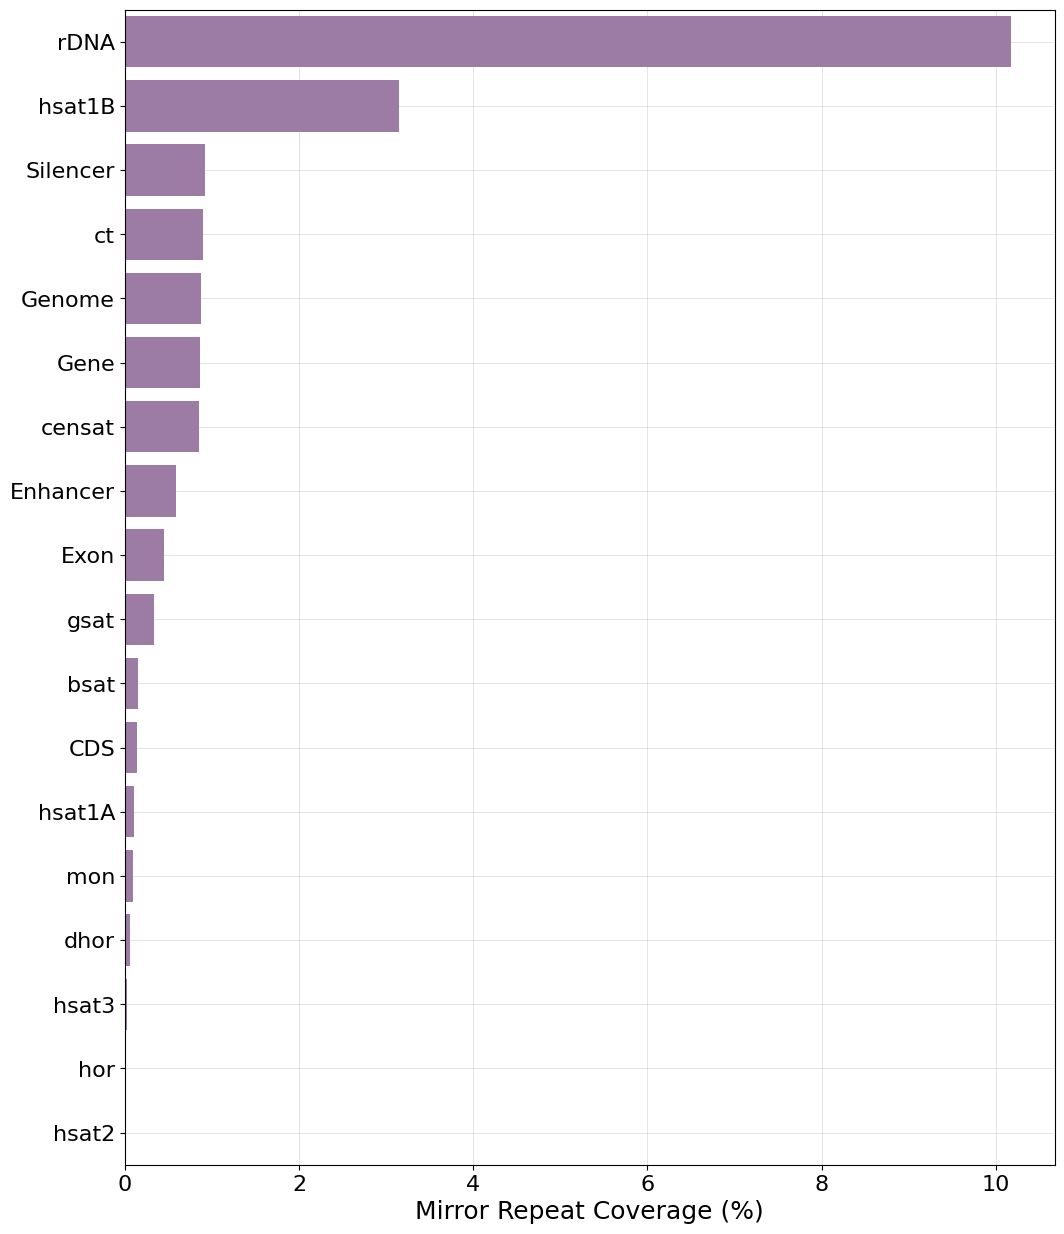

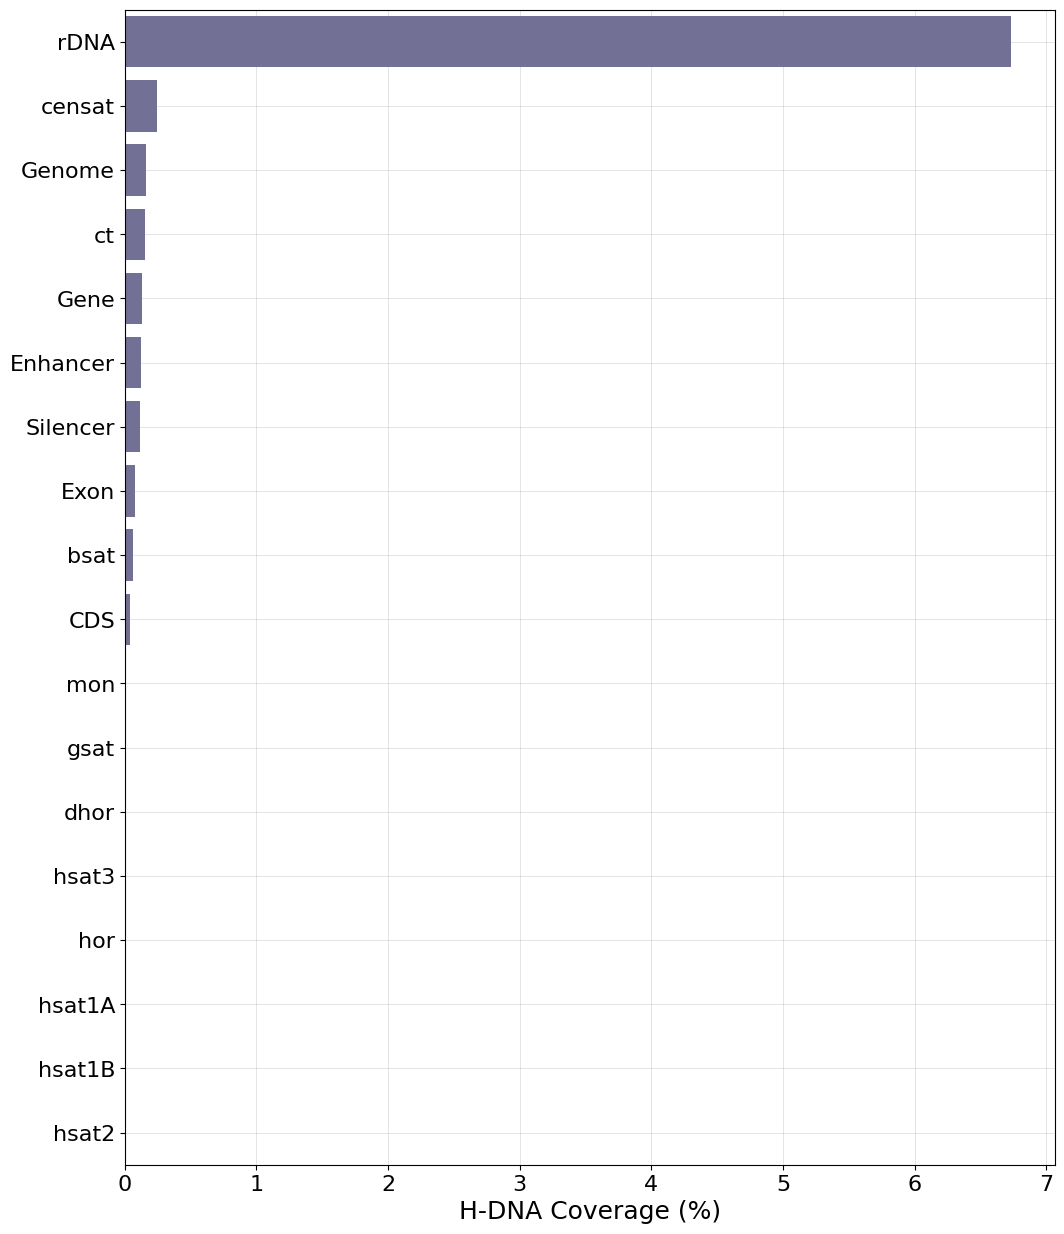

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 15))

palette={"H-DNA Motif": "#6c6b9b",
         "Mirror Repeat": "#a074ac"
        }

mirror_color = palette["Mirror Repeat"]
hdna_color = palette["H-DNA Motif"]

ax = sns.barplot(
            data=df_coverage_mirror_all, 
            capsize=.3, 
            x="density", 
            y="compartment",
            ax=ax, 
            color=mirror_color,
            # color="gray",
            order=df_coverage_mirror_all.set_index("compartment")['density']
                                .sort_values(ascending=False)\
                                .index.tolist()
           )
# ax.bar_label(ax.containers[0])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=0)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.set_xlabel("Mirror Repeat Coverage (%)")
ax.set_ylabel("")
fig.savefig(figures.joinpath("mirror_total_density_per_compartment.png"), bbox_inches='tight')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 15))
ax = sns.barplot(
            data=df_coverage_hdna_all, 
            capsize=.3, 
            x="density", 
            y="compartment",
            ax=ax, 
            color=hdna_color,
            # color="gray",
            order=df_coverage_hdna_all.set_index("compartment")['density']
                                .sort_values(ascending=False)\
                                .index.tolist()
           )
# ax.bar_label(ax.containers[0])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=0)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.set_xlabel("H-DNA Coverage (%)")
ax.set_ylabel("")
fig.savefig(figures.joinpath("hdna_total_density_per_compartment.png"), bbox_inches='tight')

## Average H-DNA Density per Genomic Subcompartment

In [57]:
average_hdna_density = df_coverage_hdna.groupby(["compartment"], 
                                         as_index=False)\
                        .agg({"coverage": "mean"}).sort_values(by=["coverage"], ascending=False).reset_index(drop=True)
average_hdna_density.to_csv("datasets/average_g4_density_per_compartment.csv", index=False, header=True, mode="w", sep="\t")
average_hdna_density

,compartment,coverage
0,rDNA,6.493300
1,bsat,0.303072
2,censat,0.244278
3,ct,0.230010
4,Genome,0.178937
5,Gene,0.154262
6,Silencer,0.133234
7,Enhancer,0.101727
8,Exon,0.052348
9,CDS,0.037412


In [58]:
figures

PosixPath('HDNA_figures')

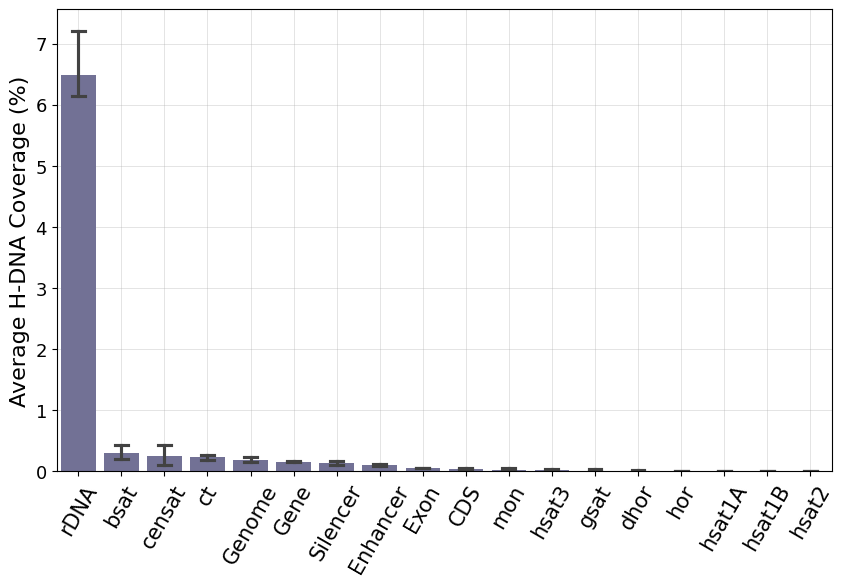

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(data=df_coverage_hdna,
            capsize=.3, 
            y="coverage", 
            x="compartment",
            ax=ax,
            errorbar=("ci", 99),
            color=hdna_color,
            order=df_coverage_hdna.groupby("compartment")\
                             .agg({"coverage": "mean"})\
                             .sort_values(by=['coverage'], ascending=False)\
                              .index.tolist()
)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=60, labelsize=15)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_ylabel("Average H-DNA Coverage (%)")
ax.set_xlabel("")
fig.savefig(figures.joinpath("average_hdna_density_per_compartment.png"), bbox_inches='tight')

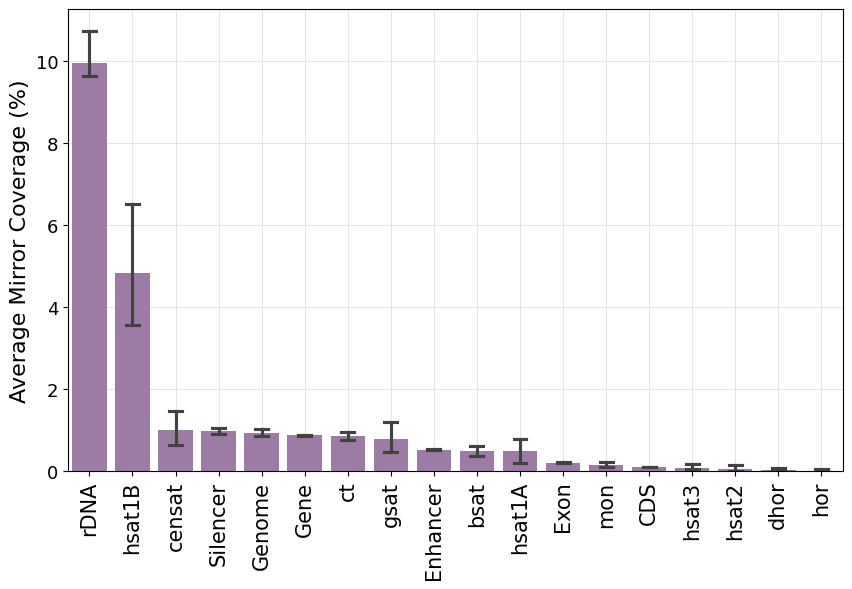

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(data=df_coverage_mirror,
            capsize=.3, 
            y="coverage", 
            x="compartment",
            ax=ax,
            errorbar=("ci", 99),
            color=mirror_color,
            order=df_coverage_mirror.groupby("compartment")\
                             .agg({"coverage": "mean"})\
                             .sort_values(by=['coverage'], ascending=False)\
                             .index.tolist()
)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=90, labelsize=15)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_ylabel("Average Mirror Coverage (%)")
ax.set_xlabel("")
fig.savefig(figures.joinpath("average_mirror_density_per_compartment.png"), bbox_inches='tight')